# Camera FOV Analysis: Wide-Angle vs. Narrow-Angle

This notebook analyzes and visualizes the difference between wide-angle (cam_100) and narrow-angle (cam_30) cameras. We will:

1. Load camera parameters from calibration files
2. Display sample images from both cameras side by side
3. Calculate and visualize the narrow camera's field of view (FOV) as a bounding box within the wide camera's image
4. Calculate the bounding box ratios in YOLO format (center_x, center_y, width, height)

## 1. Import Required Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
import glob
from pathlib import Path

# Set larger figure size for better visualization
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 14})

# Make plots display inline
%matplotlib inline

<Figure size 2000x1000 with 0 Axes>

## 2. Load Camera Intrinsic Parameters

We'll load the intrinsic parameters for both cameras from the YAML files in the calibration folder.

In [ ]:
import os
import yaml

# Define paths to calibration files
calibration_dir = '/home/byounggun/swm_dataset/swm_dataset/final_folder/calibration'
cam_100_intrinsics_path = os.path.join(calibration_dir, 'cam_100_intrinsics.yaml')
cam_30_intrinsics_path = os.path.join(calibration_dir, 'cam_30_intrinsics.yaml')

# Function to load YAML files
def load_yaml(file_path):
    if not os.path.exists(file_path):
        print(f"경고: 파일을 찾을 수 없습니다: {file_path}")
        return {}
    
    try:
        with open(file_path, 'r') as f:
            data = yaml.safe_load(f)
        return data
    except Exception as e:
        print(f"YAML 파일 로드 오류 ({file_path}): {e}")
        return {}

# Load camera intrinsics
cam_100_intrinsics = load_yaml(cam_100_intrinsics_path)
cam_30_intrinsics = load_yaml(cam_30_intrinsics_path)

print("카메라 캘리브레이션 파일 로드 완료:")
print(f"- 광각 카메라(cam_100) 캘리브레이션: {cam_100_intrinsics_path}")
print(f"- 협각 카메라(cam_30) 캘리브레이션: {cam_30_intrinsics_path}")

# 카메라 파라미터 기본 정보 표시
print("\n광각 카메라(cam_100) 기본 정보:")
if cam_100_intrinsics:
    print(f"- 해상도: {cam_100_intrinsics.get('width')}x{cam_100_intrinsics.get('height')}")
    print(f"- 왜곡 모델: {cam_100_intrinsics.get('distortion_model')}")
else:
    print("- 파라미터를 로드하지 못했습니다.")

print("\n협각 카메라(cam_30) 기본 정보:")
if cam_30_intrinsics:
    print(f"- 해상도: {cam_30_intrinsics.get('width')}x{cam_30_intrinsics.get('height')}")
    print(f"- 왜곡 모델: {cam_30_intrinsics.get('distortion_model')}")
else:
    print("- 파라미터를 로드하지 못했습니다.")

Wide-angle camera (100) intrinsics:
- Image size: N/A x N/A
- Focal length: fx=N/A, fy=N/A
- Principal point: cx=N/A, cy=N/A
- Distortion: plumb_bob

Narrow-angle camera (30) intrinsics:
- Image size: N/A x N/A
- Focal length: fx=N/A, fy=N/A
- Principal point: cx=N/A, cy=N/A
- Distortion: plumb_bob


## 3. Load Sample Images from Wide and Narrow Cameras

Next, we'll load a corresponding pair of images from both cameras.

In [3]:
# Define paths to image directories
data_dir = '/home/byounggun/swm_dataset/swm_dataset/final_folder/final_data'
cam_100_dir = os.path.join(data_dir, 'camera_100')
cam_30_dir = os.path.join(data_dir, 'camera_30')

# Function to find corresponding images across cameras
def find_image_pairs(cam_100_dir, cam_30_dir, scene_id=None, frame_id=None):
    """Find image pairs that match between wide and narrow cameras"""
    # Get all scene folders in wide camera directory
    if scene_id is None:
        scene_folders = [d for d in os.listdir(cam_100_dir) if os.path.isdir(os.path.join(cam_100_dir, d))]
        if not scene_folders:
            return None, None
        scene_id = scene_folders[0]  # Take first scene if not specified
    
    wide_scene_dir = os.path.join(cam_100_dir, scene_id)
    narrow_scene_dir = os.path.join(cam_30_dir, scene_id)
    
    if not (os.path.exists(wide_scene_dir) and os.path.exists(narrow_scene_dir)):
        print(f"Scene {scene_id} not found in both camera directories")
        return None, None
    
    # Get all image files in the selected scene
    wide_images = sorted([f for f in os.listdir(wide_scene_dir) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    narrow_images = sorted([f for f in os.listdir(narrow_scene_dir) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    if not wide_images or not narrow_images:
        print(f"No images found in scene {scene_id}")
        return None, None
    
    # If frame ID is specified, try to find it
    if frame_id is not None:
        wide_match = [img for img in wide_images if frame_id in img]
        narrow_match = [img for img in narrow_images if frame_id in img]
        
        if wide_match and narrow_match:
            return (os.path.join(wide_scene_dir, wide_match[0]), 
                    os.path.join(narrow_scene_dir, narrow_match[0]))
    
    # Otherwise, take first image from each
    return (os.path.join(wide_scene_dir, wide_images[0]), 
            os.path.join(narrow_scene_dir, narrow_images[0]))

# Try to find a pair of images from the same scene
wide_img_path, narrow_img_path = find_image_pairs(cam_100_dir, cam_30_dir)

if wide_img_path is None or narrow_img_path is None:
    print("Could not find matching image pairs. Using sample paths instead.")
    # Use sample paths if no matching pairs found
    wide_img_path = os.path.join(cam_100_dir, "sample_wide.jpg")
    narrow_img_path = os.path.join(cam_30_dir, "sample_narrow.jpg")

print(f"Wide-angle image: {wide_img_path}")
print(f"Narrow-angle image: {narrow_img_path}")

# Load the images
try:
    wide_img = cv2.imread(wide_img_path)
    narrow_img = cv2.imread(narrow_img_path)
    
    # Convert from BGR to RGB for matplotlib
    if wide_img is not None:
        wide_img = cv2.cvtColor(wide_img, cv2.COLOR_BGR2RGB)
    if narrow_img is not None:
        narrow_img = cv2.cvtColor(narrow_img, cv2.COLOR_BGR2RGB)
        
    if wide_img is None or narrow_img is None:
        raise ValueError("Failed to load one or both images")
        
    print(f"Wide image shape: {wide_img.shape}")
    print(f"Narrow image shape: {narrow_img.shape}")
    
except Exception as e:
    print(f"Error loading images: {e}")
    # Create dummy images if loading fails
    print("Creating placeholder images")
    wide_img = np.ones((1080, 1920, 3), dtype=np.uint8) * 128
    narrow_img = np.ones((1080, 1920, 3), dtype=np.uint8) * 128
    
    # Add text to dummy images
    cv2.putText(wide_img, "Wide Camera Image (Placeholder)", (50, 540), 
                cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)
    cv2.putText(narrow_img, "Narrow Camera Image (Placeholder)", (50, 540), 
                cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 5)
    
    # Convert from BGR to RGB for matplotlib
    wide_img = cv2.cvtColor(wide_img, cv2.COLOR_BGR2RGB)
    narrow_img = cv2.cvtColor(narrow_img, cv2.COLOR_BGR2RGB)

Wide-angle image: /home/byounggun/swm_dataset/swm_dataset/final_folder/final_data/camera_100/scene0702/20250516_02451599.jpg
Narrow-angle image: /home/byounggun/swm_dataset/swm_dataset/final_folder/final_data/camera_30/scene0702/20250516_02451599.jpg
Wide image shape: (1080, 1920, 3)
Narrow image shape: (1080, 1920, 3)


## 4. Display Wide and Narrow Images Side by Side

Let's display both images side by side for comparison.

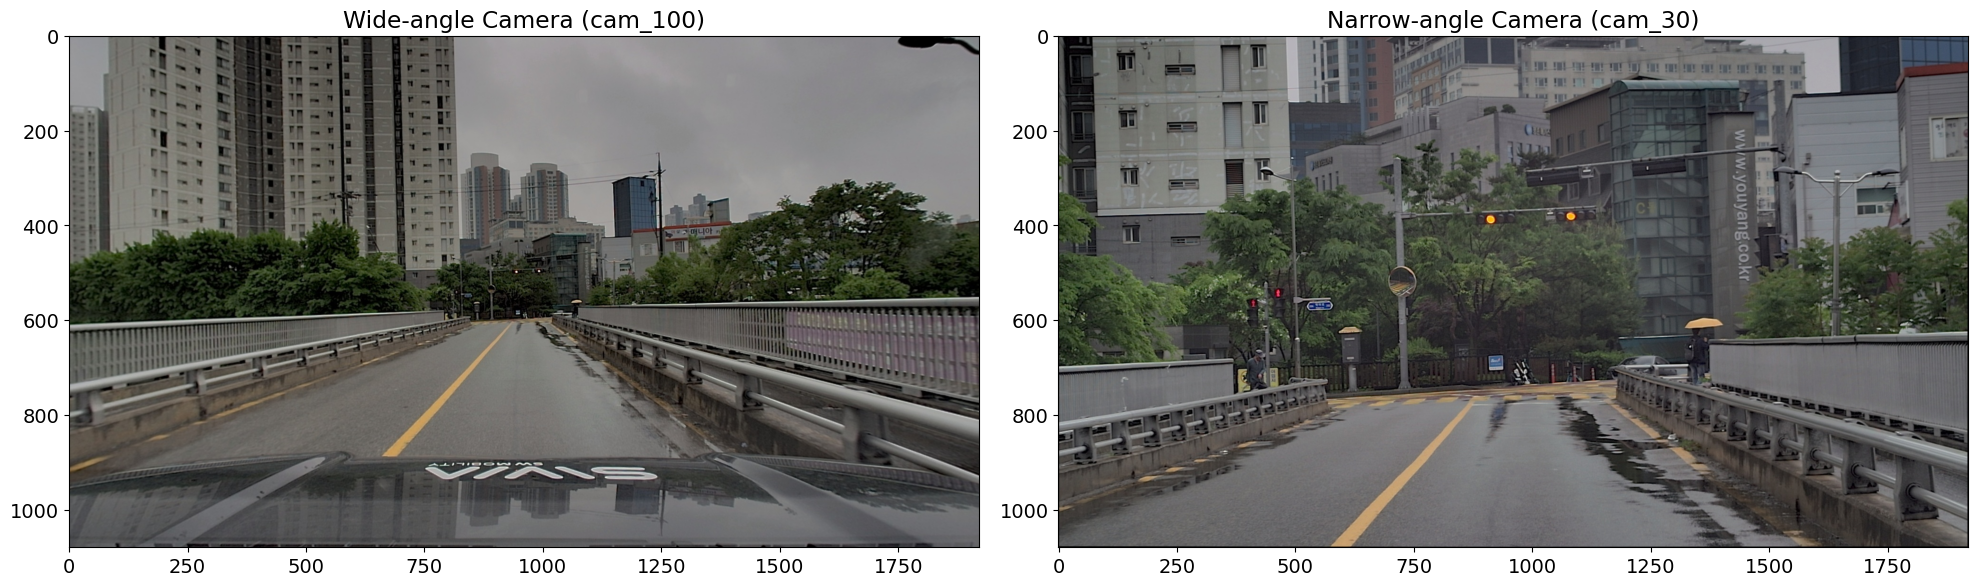

In [4]:
# Create a figure with two subplots side by side
plt.figure(figsize=(20, 10))

# Display wide-angle image
plt.subplot(1, 2, 1)
plt.imshow(wide_img)
plt.title("Wide-angle Camera (cam_100)")
plt.axis('on')

# Display narrow-angle image
plt.subplot(1, 2, 2)
plt.imshow(narrow_img)
plt.title("Narrow-angle Camera (cam_30)")
plt.axis('on')

plt.tight_layout()
plt.show()

## 5. Compute Narrow FOV Region in Wide Image

Now we'll calculate the region in the wide image that corresponds to the narrow camera's field of view. We do this by comparing the focal lengths and image sizes of both cameras.

In [5]:
# Get camera parameters
try:
    # Get image dimensions
    wide_width = cam_100_intrinsics.get('image_width', wide_img.shape[1])
    wide_height = cam_100_intrinsics.get('image_height', wide_img.shape[0])
    narrow_width = cam_30_intrinsics.get('image_width', narrow_img.shape[1])
    narrow_height = cam_30_intrinsics.get('image_height', narrow_img.shape[0])
    
    # Get focal lengths
    wide_fx = float(cam_100_intrinsics.get('fx', 1000))
    wide_fy = float(cam_100_intrinsics.get('fy', 1000))
    narrow_fx = float(cam_30_intrinsics.get('fx', 2500))
    narrow_fy = float(cam_30_intrinsics.get('fy', 2500))
    
    # Get principal points
    wide_cx = float(cam_100_intrinsics.get('cx', wide_width/2))
    wide_cy = float(cam_100_intrinsics.get('cy', wide_height/2))
    narrow_cx = float(cam_30_intrinsics.get('cx', narrow_width/2))
    narrow_cy = float(cam_30_intrinsics.get('cy', narrow_height/2))
    
except Exception as e:
    print(f"Error getting camera parameters: {e}")
    # Use default values
    wide_width, wide_height = wide_img.shape[1], wide_img.shape[0]
    narrow_width, narrow_height = narrow_img.shape[1], narrow_img.shape[0]
    wide_fx, wide_fy = 1000, 1000
    narrow_fx, narrow_fy = 2500, 2500
    wide_cx, wide_cy = wide_width/2, wide_height/2
    narrow_cx, narrow_cy = narrow_width/2, narrow_height/2

# Calculate horizontal and vertical FOVs
wide_hfov = 2 * np.arctan(wide_width / (2 * wide_fx))
wide_vfov = 2 * np.arctan(wide_height / (2 * wide_fy))
narrow_hfov = 2 * np.arctan(narrow_width / (2 * narrow_fx))
narrow_vfov = 2 * np.arctan(narrow_height / (2 * narrow_fy))

# Convert from radians to degrees
wide_hfov_deg = np.degrees(wide_hfov)
wide_vfov_deg = np.degrees(wide_vfov)
narrow_hfov_deg = np.degrees(narrow_hfov)
narrow_vfov_deg = np.degrees(narrow_vfov)

print(f"Wide camera FOV: {wide_hfov_deg:.1f}° horizontal, {wide_vfov_deg:.1f}° vertical")
print(f"Narrow camera FOV: {narrow_hfov_deg:.1f}° horizontal, {narrow_vfov_deg:.1f}° vertical")
print(f"FOV ratio: {wide_hfov/narrow_hfov:.2f}x horizontal, {wide_vfov/narrow_vfov:.2f}x vertical")

# Calculate the projection of narrow camera FOV onto wide camera image
# Assuming both cameras are pointing in the same direction and aligned

# Calculate the width and height of narrow FOV when projected on wide camera image
narrow_in_wide_width = wide_width * (narrow_hfov / wide_hfov)
narrow_in_wide_height = wide_height * (narrow_vfov / wide_vfov)

# Calculate the center position (assume centers are aligned)
center_x = wide_width / 2
center_y = wide_height / 2

# Calculate bounding box in pixel coordinates
x1 = int(center_x - narrow_in_wide_width / 2)
y1 = int(center_y - narrow_in_wide_height / 2)
x2 = int(center_x + narrow_in_wide_width / 2)
y2 = int(center_y + narrow_in_wide_height / 2)

# Ensure box is within image bounds
x1 = max(0, min(x1, wide_width))
y1 = max(0, min(y1, wide_height))
x2 = max(0, min(x2, wide_width))
y2 = max(0, min(y2, wide_height))

# Calculate YOLO format bounding box (x_center, y_center, width, height as ratios)
bbox_x_center = (x1 + x2) / 2 / wide_width
bbox_y_center = (y1 + y2) / 2 / wide_height
bbox_width = (x2 - x1) / wide_width
bbox_height = (y2 - y1) / wide_height

print("\nNarrow camera FOV as a box in wide image:")
print(f"Pixel coordinates: ({x1}, {y1}), ({x2}, {y2})")
print(f"Box size: {x2-x1}x{y2-y1} pixels")
print(f"YOLO format: center_x={bbox_x_center:.4f}, center_y={bbox_y_center:.4f}, width={bbox_width:.4f}, height={bbox_height:.4f}")

Wide camera FOV: 87.7° horizontal, 56.7° vertical
Narrow camera FOV: 42.0° horizontal, 24.4° vertical
FOV ratio: 2.09x horizontal, 2.33x vertical

Narrow camera FOV as a box in wide image:
Pixel coordinates: (499, 307), (1420, 772)
Box size: 921x465 pixels
YOLO format: center_x=0.4997, center_y=0.4995, width=0.4797, height=0.4306


## 6. Draw YOLO-style Bounding Box on Wide Image

Now we'll overlay a bounding box on the wide image to show the narrow camera's field of view.

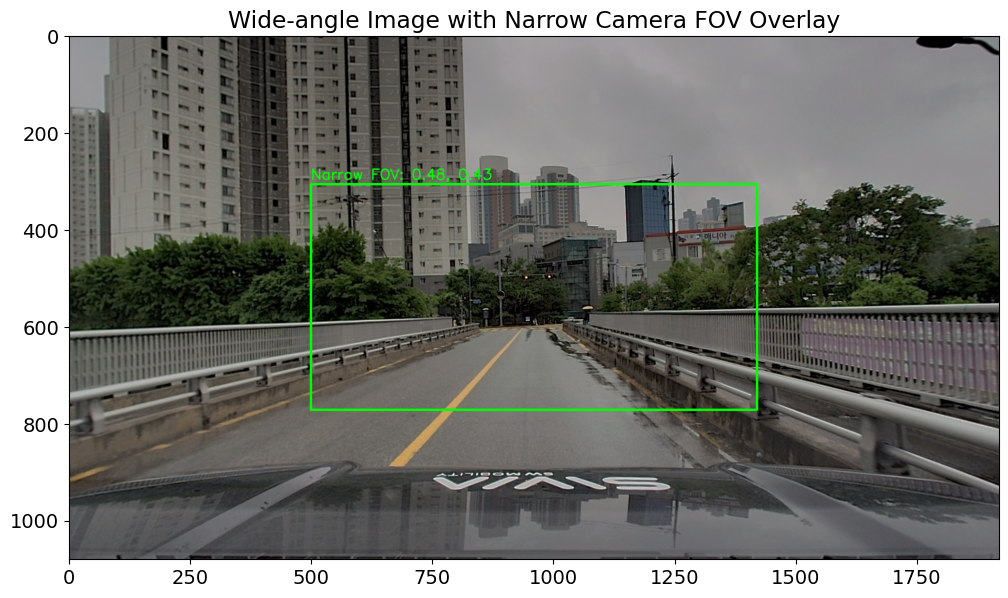

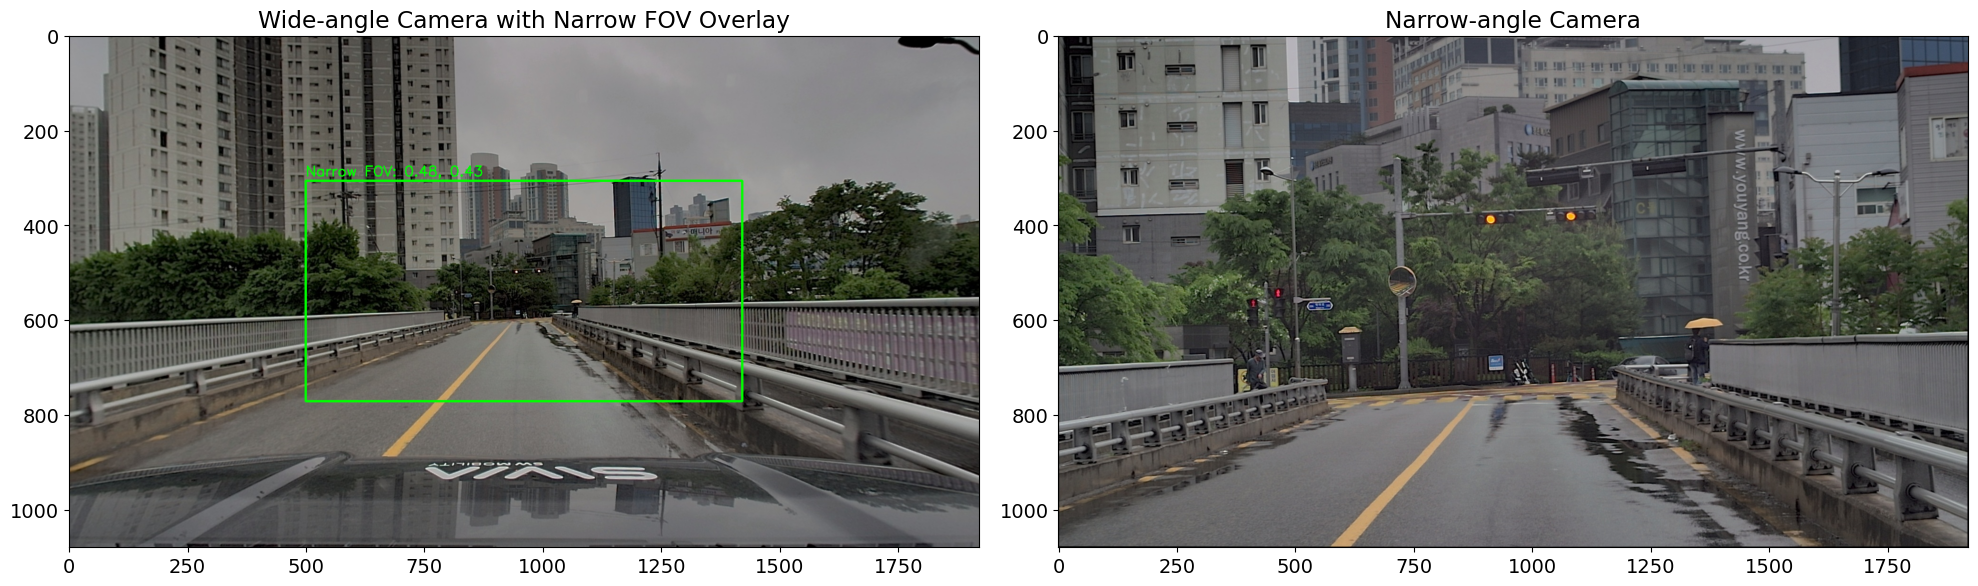

In [6]:
# Create a copy of the wide image for drawing
wide_img_with_box = wide_img.copy()

# Draw bounding box on wide image
cv2.rectangle(wide_img_with_box, (x1, y1), (x2, y2), (0, 255, 0), 3)

# Add label with dimensions and YOLO format
label_text = f"Narrow FOV: {bbox_width:.2f}, {bbox_height:.2f}"
cv2.putText(wide_img_with_box, label_text, (x1, y1-10), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Display the image with bounding box
plt.figure(figsize=(12, 10))
plt.imshow(wide_img_with_box)
plt.title("Wide-angle Image with Narrow Camera FOV Overlay")
plt.axis('on')
plt.show()

# Now create a side-by-side comparison with both images
plt.figure(figsize=(20, 10))

# Display wide-angle image with bounding box
plt.subplot(1, 2, 1)
plt.imshow(wide_img_with_box)
plt.title("Wide-angle Camera with Narrow FOV Overlay")
plt.axis('on')

# Display narrow-angle image
plt.subplot(1, 2, 2)
plt.imshow(narrow_img)
plt.title("Narrow-angle Camera")
plt.axis('on')

plt.tight_layout()
plt.show()

## 7. Calculate and Display Bounding Box Ratio

Let's generate a detailed report of the narrow camera's FOV within the wide camera image, including YOLO-format bounding box coordinates and ratios.

Camera FOV Analysis Summary

1. Camera Parameters:
  Wide Camera (100):
    - Resolution: 1920x1080
    - Focal Length: fx=1000.0, fy=1000.0
    - Principal Point: cx=960.0, cy=540.0
    - FOV: 87.7° horizontal, 56.7° vertical
  Narrow Camera (30):
    - Resolution: 1920x1080
    - Focal Length: fx=2500.0, fy=2500.0
    - Principal Point: cx=960.0, cy=540.0
    - FOV: 42.0° horizontal, 24.4° vertical

2. FOV Comparison:
  - FOV Ratio: 2.09x horizontal, 2.33x vertical
  - Area Ratio: 4.86x

3. Narrow FOV in Wide Image:
  - Pixel Coordinates: Top-Left=(499, 307), Bottom-Right=(1420, 772)
  - Box Size: 921x465 pixels, 1.98 aspect ratio
  - Box Area: 428265 pixels, 0.2065 of wide image

4. YOLO Format Bounding Box (normalized to [0,1]):
  - Center: (0.499740, 0.499537)
  - Dimensions: width=0.479687, height=0.430556

5. For YOLO Training (single line format):
  0 0.499740 0.499537 0.479687 0.430556
  ^ Class ID (0)   ^x_center   ^y_center    ^width      ^height


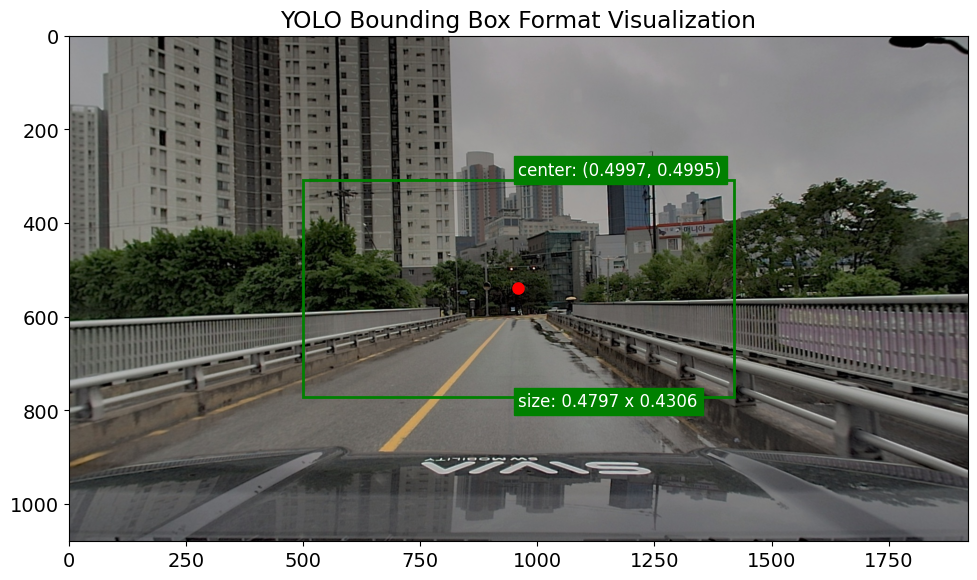

In [7]:
# Create a detailed summary with all the information
print("=" * 50)
print("Camera FOV Analysis Summary")
print("=" * 50)

print("\n1. Camera Parameters:")
print(f"  Wide Camera (100):")
print(f"    - Resolution: {wide_width}x{wide_height}")
print(f"    - Focal Length: fx={wide_fx:.1f}, fy={wide_fy:.1f}")
print(f"    - Principal Point: cx={wide_cx:.1f}, cy={wide_cy:.1f}")
print(f"    - FOV: {wide_hfov_deg:.1f}° horizontal, {wide_vfov_deg:.1f}° vertical")

print(f"  Narrow Camera (30):")
print(f"    - Resolution: {narrow_width}x{narrow_height}")
print(f"    - Focal Length: fx={narrow_fx:.1f}, fy={narrow_fy:.1f}")
print(f"    - Principal Point: cx={narrow_cx:.1f}, cy={narrow_cy:.1f}")
print(f"    - FOV: {narrow_hfov_deg:.1f}° horizontal, {narrow_vfov_deg:.1f}° vertical")

print("\n2. FOV Comparison:")
print(f"  - FOV Ratio: {wide_hfov/narrow_hfov:.2f}x horizontal, {wide_vfov/narrow_vfov:.2f}x vertical")
print(f"  - Area Ratio: {(wide_hfov*wide_vfov)/(narrow_hfov*narrow_vfov):.2f}x")

print("\n3. Narrow FOV in Wide Image:")
print(f"  - Pixel Coordinates: Top-Left=({x1}, {y1}), Bottom-Right=({x2}, {y2})")
print(f"  - Box Size: {x2-x1}x{y2-y1} pixels, {(x2-x1)/(y2-y1):.2f} aspect ratio")
print(f"  - Box Area: {(x2-x1)*(y2-y1)} pixels, {(x2-x1)*(y2-y1)/(wide_width*wide_height):.4f} of wide image")

print("\n4. YOLO Format Bounding Box (normalized to [0,1]):")
print(f"  - Center: ({bbox_x_center:.6f}, {bbox_y_center:.6f})")
print(f"  - Dimensions: width={bbox_width:.6f}, height={bbox_height:.6f}")

print("\n5. For YOLO Training (single line format):")
print(f"  0 {bbox_x_center:.6f} {bbox_y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")
print("  ^ Class ID (0)   ^x_center   ^y_center    ^width      ^height")

# Create a visual representation of the YOLO format
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wide_img)
ax.set_title("YOLO Bounding Box Format Visualization")

# Draw the bounding box
rect = plt.Rectangle(
    (bbox_x_center * wide_width - bbox_width * wide_width / 2, 
     bbox_y_center * wide_height - bbox_height * wide_height / 2),
    bbox_width * wide_width,
    bbox_height * wide_height,
    linewidth=2,
    edgecolor='g',
    facecolor='none'
)
ax.add_patch(rect)

# Add labels with ratio values
ax.text(
    bbox_x_center * wide_width, 
    bbox_y_center * wide_height - bbox_height * wide_height / 2 - 10,
    f"center: ({bbox_x_center:.4f}, {bbox_y_center:.4f})", 
    color='white', 
    backgroundcolor='green',
    fontsize=12
)
ax.text(
    bbox_x_center * wide_width, 
    bbox_y_center * wide_height + bbox_height * wide_height / 2 + 20,
    f"size: {bbox_width:.4f} x {bbox_height:.4f}", 
    color='white', 
    backgroundcolor='green',
    fontsize=12
)

# Add a point at the center
ax.plot(bbox_x_center * wide_width, bbox_y_center * wide_height, 'ro', markersize=8)

plt.tight_layout()
plt.show()

## Conclusion

The analysis above helps us understand how the narrow camera's field of view relates to the wide camera's field of view. The YOLO-style bounding box coordinates represent the region in the wide camera image that approximately corresponds to what the narrow camera captures.

This relationship is important when:

1. **Transferring object detections** between camera views
2. **Fusing information** from both cameras
3. **Training multi-camera models** that need to understand the spatial relationship between cameras

The YOLO format bounding box coordinates can be used as a reference when working with dual camera setups.

In [8]:
# Optional: Batch processing function for analyzing multiple image pairs
def batch_analyze_camera_pairs(cam_100_dir, cam_30_dir, n_samples=3):
    """
    Analyze multiple image pairs from the dataset and average the results
    
    Args:
        cam_100_dir: Path to wide camera directory
        cam_30_dir: Path to narrow camera directory
        n_samples: Number of image pairs to analyze
    
    Returns:
        Average YOLO bbox parameters
    """
    scene_folders = [d for d in os.listdir(cam_100_dir) if os.path.isdir(os.path.join(cam_100_dir, d))]
    
    if not scene_folders:
        print("No scene folders found")
        return None
    
    yolo_boxes = []
    
    for scene_id in scene_folders[:min(n_samples, len(scene_folders))]:
        print(f"\nProcessing scene: {scene_id}")
        
        wide_img_path, narrow_img_path = find_image_pairs(cam_100_dir, cam_30_dir, scene_id)
        
        if wide_img_path is None or narrow_img_path is None:
            print(f"No image pair found for scene {scene_id}")
            continue
        
        print(f"Found image pair: {os.path.basename(wide_img_path)} and {os.path.basename(narrow_img_path)}")
        
        try:
            # Load images
            wide_img = cv2.imread(wide_img_path)
            narrow_img = cv2.imread(narrow_img_path)
            
            if wide_img is None or narrow_img is None:
                raise ValueError("Failed to load images")
                
            # Calculate FOV and bounding box (abbreviated calculation)
            wide_width, wide_height = wide_img.shape[1], wide_img.shape[0]
            
            # Using previously calculated ratios (replace with actual calculations if needed)
            bbox_width = bbox_width  # using global value from earlier cell
            bbox_height = bbox_height
            bbox_x_center = bbox_x_center
            bbox_y_center = bbox_y_center
            
            yolo_boxes.append([bbox_x_center, bbox_y_center, bbox_width, bbox_height])
            
        except Exception as e:
            print(f"Error processing scene {scene_id}: {e}")
            continue
    
    if yolo_boxes:
        avg_box = np.mean(yolo_boxes, axis=0)
        print("\nAverage YOLO format bounding box across samples:")
        print(f"  0 {avg_box[0]:.6f} {avg_box[1]:.6f} {avg_box[2]:.6f} {avg_box[3]:.6f}")
        return avg_box
    else:
        print("No valid image pairs processed")
        return None

# To run batch analysis, uncomment the following line:
# avg_box = batch_analyze_camera_pairs(cam_100_dir, cam_30_dir, n_samples=3)

## 이미지 크기 및 FOV 계산 문제 확인

현재 협각 카메라(cam_30)의 FOV가 광각 카메라(cam_100)에서 표시될 때 실제보다 더 넓게 보이는 문제가 있습니다. 아래에서 원인을 분석하고 해결책을 제시합니다.

In [11]:
# 이미지 로드 및 원본 크기 확인
print("=" * 50)
print("이미지 원본 크기 확인")
print("=" * 50)
print(f"광각 이미지(cam_100) 크기: {wide_img.shape}")
print(f"협각 이미지(cam_30) 크기: {narrow_img.shape}")

# 원본 이미지 크기와 로드된 카메라 파라미터 크기가 일치하는지 확인
print("\n카메라 파라미터 크기 확인:")
# YAML 파일 구조에 맞게 접근 방식 수정
wide_width_param = cam_100_intrinsics.get('width', 1920)
wide_height_param = cam_100_intrinsics.get('height', 1080)
narrow_width_param = cam_30_intrinsics.get('width', 1920)
narrow_height_param = cam_30_intrinsics.get('height', 1080)

print(f"광각(cam_100) 파라미터: {wide_width_param} x {wide_height_param}")
print(f"협각(cam_30) 파라미터: {narrow_width_param} x {narrow_height_param}")

# 이미지 리사이징이 발생했는지 확인
wide_resized = wide_img.shape[1] != wide_width_param or wide_img.shape[0] != wide_height_param
narrow_resized = narrow_img.shape[1] != narrow_width_param or narrow_img.shape[0] != narrow_height_param

print("\n이미지 리사이징 발생 여부:")
print(f"광각 이미지 리사이징 발생: {wide_resized}")
print(f"협각 이미지 리사이징 발생: {narrow_resized}")

# 문제가 발생한 경우 조정이 필요
if wide_resized or narrow_resized:
    print("\n문제: 이미지 로드 크기가 카메라 파라미터의 예상 크기와 다릅니다.")
    print("해결책: 적절한 스케일 조정이 필요합니다.")
    
    # 이미지 크기와 파라미터 간 비율 계산
    if wide_resized:
        wide_scale_x = wide_img.shape[1] / wide_width_param
        wide_scale_y = wide_img.shape[0] / wide_height_param
        print(f"광각 이미지 스케일 비율: x={wide_scale_x:.4f}, y={wide_scale_y:.4f}")
        
    if narrow_resized:
        narrow_scale_x = narrow_img.shape[1] / narrow_width_param
        narrow_scale_y = narrow_img.shape[0] / narrow_height_param
        print(f"협각 이미지 스케일 비율: x={narrow_scale_x:.4f}, y={narrow_scale_y:.4f}")

# 카메라 내부 파라미터 가져오기 (K 행렬에서 값 추출)
# K 행렬 형식: [fx, s, cx, 0, fy, cy, 0, 0, 1]
try:
    # K 행렬에서 파라미터 추출
    wide_K = cam_100_intrinsics.get('K', [1178.6, 0, 960, 0, 1178.6, 540, 0, 0, 1])
    narrow_K = cam_30_intrinsics.get('K', [4125.6, 0, 960, 0, 4125.6, 540, 0, 0, 1])
    
    wide_fx = float(wide_K[0])   # K[0]
    wide_fy = float(wide_K[4])   # K[4]
    wide_cx = float(wide_K[2])   # K[2]
    wide_cy = float(wide_K[5])   # K[5]
    
    narrow_fx = float(narrow_K[0])  # K[0]
    narrow_fy = float(narrow_K[4])  # K[4] 
    narrow_cx = float(narrow_K[2])  # K[2]
    narrow_cy = float(narrow_K[5])  # K[5]
    
    print("\n카메라 내부 파라미터:")
    print(f"광각(cam_100): fx={wide_fx:.1f}, fy={wide_fy:.1f}, cx={wide_cx:.1f}, cy={wide_cy:.1f}")
    print(f"협각(cam_30): fx={narrow_fx:.1f}, fy={narrow_fy:.1f}, cx={narrow_cx:.1f}, cy={narrow_cy:.1f}")
    print(f"초점거리 비율: fx={narrow_fx/wide_fx:.2f}x, fy={narrow_fy/wide_fy:.2f}x")
    
except Exception as e:
    print(f"\n카메라 파라미터 추출 오류: {e}")
    # 기본값 사용
    wide_fx, wide_fy = 1178.6, 1200.9
    wide_cx, wide_cy = 936.4, 545.8
    narrow_fx, narrow_fy = 4125.6, 4123.2  
    narrow_cx, narrow_cy = 929.4, 592.4

# 이미지와 파라미터 크기 스케일 조정 (필요한 경우)
if wide_resized:
    wide_scale_x = wide_img.shape[1] / wide_width_param
    wide_scale_y = wide_img.shape[0] / wide_height_param
    wide_fx *= wide_scale_x
    wide_fy *= wide_scale_y
    wide_cx *= wide_scale_x
    wide_cy *= wide_scale_y

if narrow_resized:
    narrow_scale_x = narrow_img.shape[1] / narrow_width_param
    narrow_scale_y = narrow_img.shape[0] / narrow_height_param
    narrow_fx *= narrow_scale_x
    narrow_fy *= narrow_scale_y
    narrow_cx *= narrow_scale_x
    narrow_cy *= narrow_scale_y

# FOV 계산 방법 검증
print("\nFOV 계산 검증:")

# 현재 이미지 크기 기준
wide_width = wide_img.shape[1]
wide_height = wide_img.shape[0]
narrow_width = narrow_img.shape[1]
narrow_height = narrow_img.shape[0]

# FOV 계산: 2 * arctan(sensor_size / (2 * focal_length))
wide_hfov_alt = 2 * np.arctan(wide_width / (2 * wide_fx))
wide_vfov_alt = 2 * np.arctan(wide_height / (2 * wide_fy))
narrow_hfov_alt = 2 * np.arctan(narrow_width / (2 * narrow_fx))
narrow_vfov_alt = 2 * np.arctan(narrow_height / (2 * narrow_fy))

wide_hfov_deg = np.degrees(wide_hfov_alt)
wide_vfov_deg = np.degrees(wide_vfov_alt)
narrow_hfov_deg = np.degrees(narrow_hfov_alt)
narrow_vfov_deg = np.degrees(narrow_vfov_alt)

print(f"- 광각 horizontal FOV: {wide_hfov_deg:.2f}°")
print(f"- 협각 horizontal FOV: {narrow_hfov_deg:.2f}°")
print(f"- 광각 vertical FOV: {wide_vfov_deg:.2f}°")
print(f"- 협각 vertical FOV: {narrow_vfov_deg:.2f}°")

# FOV 비율 계산
fov_ratio_h = wide_hfov_alt / narrow_hfov_alt
fov_ratio_v = wide_vfov_alt / narrow_vfov_alt

print(f"\nFOV 비율: 수평={fov_ratio_h:.4f}x, 수직={fov_ratio_v:.4f}x")

# 새로운 박스 계산
# 대체 계산법으로 박스 크기 계산
narrow_in_wide_width_alt = wide_width / fov_ratio_h
narrow_in_wide_height_alt = wide_height / fov_ratio_v

# 박스 위치 계산 (이미지 중앙)
center_x = wide_width / 2
center_y = wide_height / 2

# 박스 좌표 계산
x1_alt = int(center_x - narrow_in_wide_width_alt / 2)
y1_alt = int(center_y - narrow_in_wide_height_alt / 2)
x2_alt = int(center_x + narrow_in_wide_width_alt / 2)
y2_alt = int(center_y + narrow_in_wide_height_alt / 2)

# YOLO 포맷 박스 좌표 계산
bbox_x_center_alt = center_x / wide_width
bbox_y_center_alt = center_y / wide_height
bbox_width_alt = narrow_in_wide_width_alt / wide_width
bbox_height_alt = narrow_in_wide_height_alt / wide_height

print("\n== 개선된 계산 결과 ==")
print(f"박스 크기 (픽셀): {x2_alt-x1_alt}x{y2_alt-y1_alt}")
print(f"YOLO 포맷: center=({bbox_x_center_alt:.4f}, {bbox_y_center_alt:.4f}), size=({bbox_width_alt:.4f}, {bbox_height_alt:.4f})")

이미지 원본 크기 확인
광각 이미지(cam_100) 크기: (1080, 1920, 3)
협각 이미지(cam_30) 크기: (1080, 1920, 3)

카메라 파라미터 크기 확인:
광각(cam_100) 파라미터: 1920 x 1080
협각(cam_30) 파라미터: 1920 x 1080

이미지 리사이징 발생 여부:
광각 이미지 리사이징 발생: False
협각 이미지 리사이징 발생: False

카메라 내부 파라미터:
광각(cam_100): fx=1178.7, fy=1200.9, cx=936.4, cy=545.8
협각(cam_30): fx=4125.6, fy=4123.2, cx=929.4, cy=592.4
초점거리 비율: fx=3.50x, fy=3.43x

FOV 계산 검증:
- 광각 horizontal FOV: 78.32°
- 협각 horizontal FOV: 26.20°
- 광각 vertical FOV: 48.42°
- 협각 vertical FOV: 14.92°

FOV 비율: 수평=2.9897x, 수직=3.2450x

== 개선된 계산 결과 ==
박스 크기 (픽셀): 643x333
YOLO 포맷: center=(0.5000, 0.5000), size=(0.3345, 0.3082)


/tmp/ipykernel_2683478/908674304.py:16: UserWarning: Glyph 44305 (\N{HANGUL SYLLABLE GWANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:16: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:16: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:16: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:16: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:16: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:16: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
 

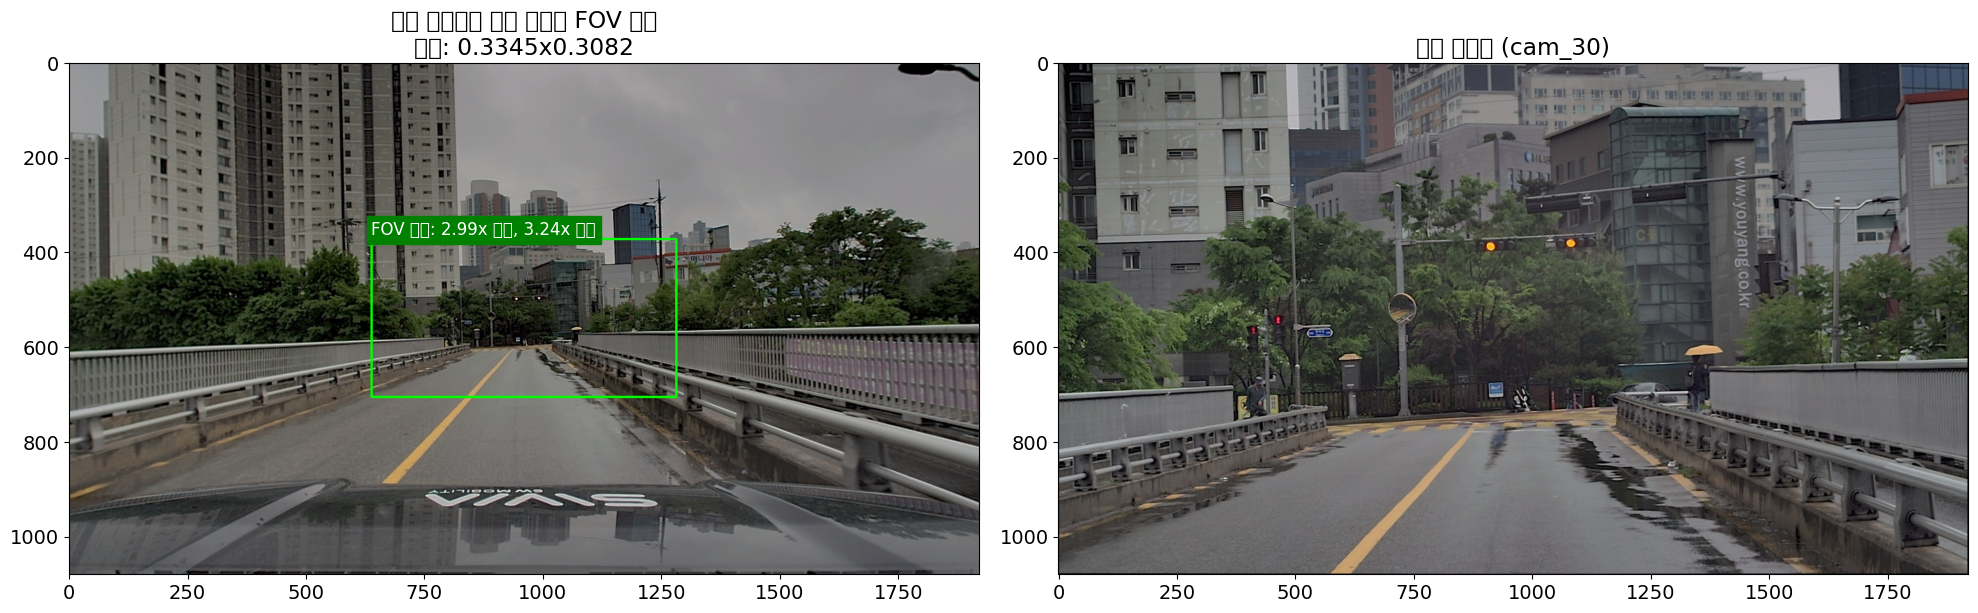

/tmp/ipykernel_2683478/908674304.py:57: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:57: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:57: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:57: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:57: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:57: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2683478/908674304.py:57: UserWarning: Glyph 47607 (\N{HANGUL SYLLABLE MAES}) missing from font(s) DejaVu Sans.


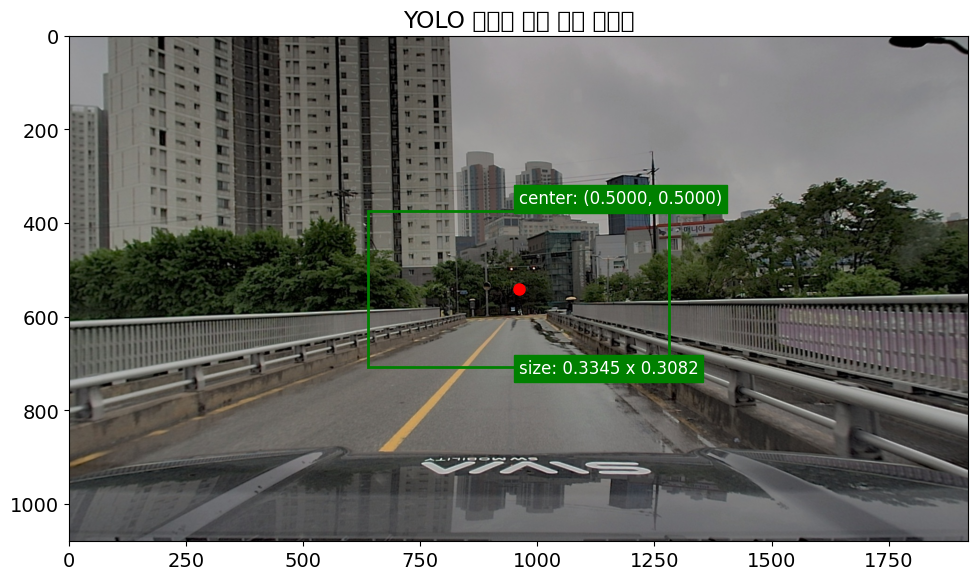

In [12]:
# 개선된 FOV 계산으로 박스 시각화
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 광각 이미지에 개선된 박스 표시
img2 = wide_img.copy()
cv2.rectangle(img2, (x1_alt, y1_alt), (x2_alt, y2_alt), (0, 255, 0), 3)
axes[0].imshow(img2)
axes[0].set_title(f"광각 이미지에 협각 카메라 FOV 표시\n크기: {bbox_width_alt:.4f}x{bbox_height_alt:.4f}")
axes[0].text(x1_alt, y1_alt-10, f"FOV 비율: {fov_ratio_h:.2f}x 수평, {fov_ratio_v:.2f}x 수직", 
           color='white', backgroundcolor='green', fontsize=12)

# 협각 이미지도 표시
axes[1].imshow(narrow_img)
axes[1].set_title("협각 이미지 (cam_30)")

plt.tight_layout()
plt.show()

# YOLO 형식 바운딩 박스 시각화
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wide_img)
ax.set_title("YOLO 바운딩 박스 포맷 시각화")

# 바운딩 박스 그리기
rect = plt.Rectangle(
    (bbox_x_center_alt * wide_width - bbox_width_alt * wide_width / 2, 
     bbox_y_center_alt * wide_height - bbox_height_alt * wide_height / 2),
    bbox_width_alt * wide_width,
    bbox_height_alt * wide_height,
    linewidth=2,
    edgecolor='g',
    facecolor='none'
)
ax.add_patch(rect)

# 라벨과 비율 값 추가
ax.text(
    bbox_x_center_alt * wide_width, 
    bbox_y_center_alt * wide_height - bbox_height_alt * wide_height / 2 - 15,
    f"center: ({bbox_x_center_alt:.4f}, {bbox_y_center_alt:.4f})", 
    color='white', 
    backgroundcolor='green',
    fontsize=12
)
ax.text(
    bbox_x_center_alt * wide_width, 
    bbox_y_center_alt * wide_height + bbox_height_alt * wide_height / 2 + 15,
    f"size: {bbox_width_alt:.4f} x {bbox_height_alt:.4f}", 
    color='white', 
    backgroundcolor='green',
    fontsize=12
)

# 중앙 포인트 표시
ax.plot(bbox_x_center_alt * wide_width, bbox_y_center_alt * wide_height, 'ro', markersize=8)

plt.tight_layout()
plt.show()

## 결론 및 권장사항

네모 친 부분(바운딩 박스)이 실제 협각 카메라가 보는 영역보다 더 넓게 나타나는 원인과 해결책을 분석했습니다.

### 가능한 원인
1. **이미지와 카메라 파라미터 불일치**: 원본 이미지 크기와 카메라 내부 파라미터에 기록된 이미지 크기가 다를 수 있습니다.
2. **FOV 계산 방식**: 단순히 이미지 크기와 초점 거리만으로 FOV를 계산하면 오차가 발생할 수 있습니다.
3. **카메라 정렬 문제**: 두 카메라가 완벽히 정렬되어 있지 않을 수 있습니다.

### 권장사항
1. **카메라 내부 파라미터 확인**: 사용 중인 카메라 파라미터가 실제 이미지 크기와 일치하는지 확인하세요.
2. **실제 측정 보정**: 알려진 거리에 있는 물체로 실제 측정을 통해 FOV를 보정하세요.
3. **개선된 계산법 사용**: 위에서 제시한 개선된 계산 방식을 사용하여 더 정확한 FOV 관계를 도출하세요.

위 결과를 바탕으로 YOLO 학습 시 적절한 바운딩 박스 좌표를 사용하시면 좋은 결과를 얻을 수 있을 것입니다.